# Data Science Project Planning

## Data Description

### Player Data

Player data has 196 observations and 7 variables.

Two numerical variables:

  + played_hours: total hours played by a player
  + Age: age of player

Four character variables:

  + experience: level of the player 
  + hashedEmail: anonymized email for privacy.
  + name: player's first name
  + gender: player's gender

One logical variable:

  + subscribe: whether the player is subscribed to game-related newsletter

Summary stats (see Exploratory section for how data was obtained):
* Age Range: [9,58]
* Age Average: 21 (21.14)
* Played Hours Range: [0, 223.1]
* Played Hours Average: 5.85 hours

Potential Issues:
* How was played hours measured? (Self reported or tracked?)
* Wide age range may skew results.
* Experience levels may be inconsistently defined if self-reported.
* N/A values in data may skew results

### Sessions Data

The sessions data has 1535 observations and 5 variables.

Two numerical variables:

  + original_start_time and original_end_time: session start and end times in UNIX milliseconds.

Three character variables:

  + start_time and end_time: human-readable versions of the above.
  + hashedEmail links sessions to players.

Summary stats for the numerical timestamps are not meaningful without computing session durations.

Potential Issues:
* Unclear time zone handling across sessions.
* Possible missing or inconsistent start/end times.
* Multiple emails per player could fragment data.
* Missing (NA) values could bias results.

## Questions

Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific Question: Can player characteristics (experience and age) predict total hours played in the player dataset?

Wrangling: To prepare the data for KNN classification, I will convert played_hours into a new factor variable, activity_level, with three categories: Low, Medium, and High. The experience variable will be transformed into a numerical scale from 1 to 5. Both experience and Age will then be standardized to ensure they are on comparable scales for KNN. While a secondary dataset (sessions.csv) is available, it mainly records session times rather than player characteristics, so only players.csv will be used to focus on predictors that describe the type of player contributing the most data.

## Exploratory Data Analysis and Visualization

In [55]:
library(tidyverse)
sessions <- read_csv("sessions.csv")
players <- read_csv("players.csv")


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [57]:
players <- rename(players, hashed_email = hashedEmail, age = Age) #variable names are all consistent

players_summary <- summarise(players,
  age_min = min(age, na.rm=TRUE),
  age_max = max(age, na.rm=TRUE),
  age_mean = mean(age, na.rm=TRUE),
  played_hours_min = min(played_hours, na.rm=TRUE),
  played_hours_max = max(played_hours, na.rm=TRUE),
  played_hours_mean = mean(played_hours, na.rm=TRUE)
)
players_summary

age_min,age_max,age_mean,played_hours_min,played_hours_max,played_hours_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,58,21.13918,0,223.1,5.845918


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


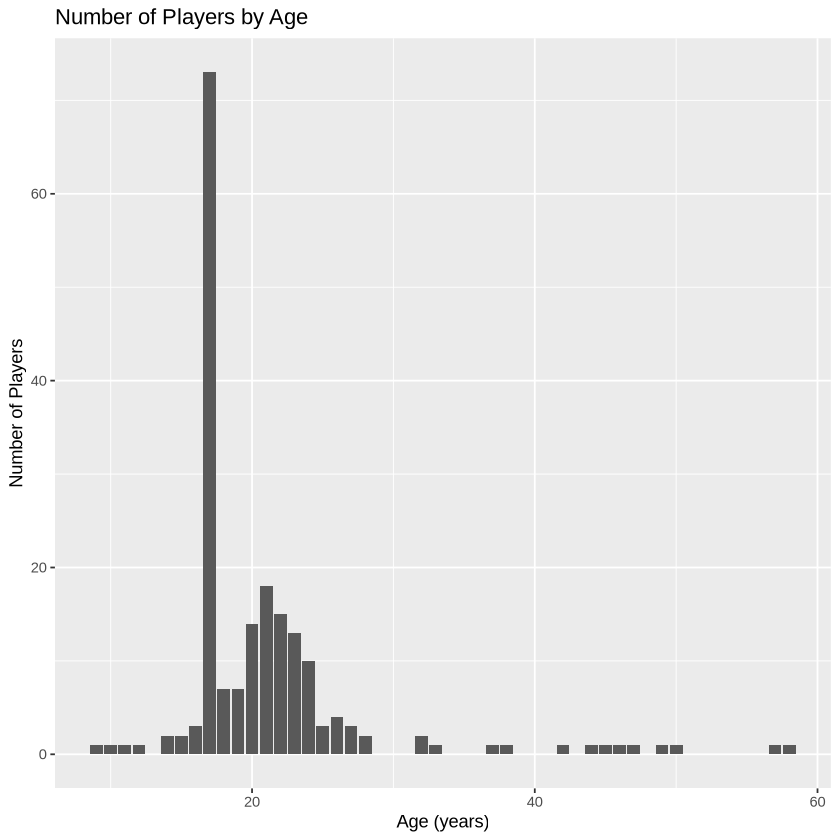

In [65]:
age_plot <- ggplot(players, aes(x = age)) +
  geom_bar() +
  labs(title = "Number of Players by Age", x = "Age (years)", y = "Number of Players")
age_plot

This plot shows that the most common participant age is around 17, and most players are between 15 and 30 years old. This concentration is important for identifying which age groups to target for recruitment.

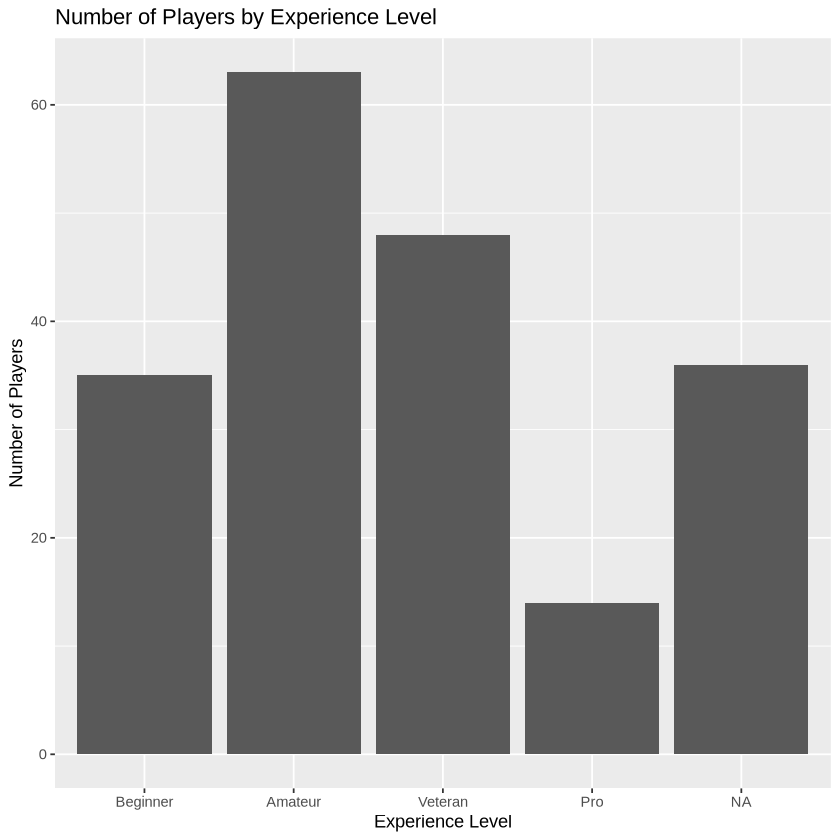

In [90]:
players_exp_order <- players |>
  mutate(experience = factor(experience, 
                             levels = c("Beginner", "Amateur", "Normal", "Veteran", "Pro")))

experience_plot <- ggplot(players_exp_order, aes(x = experience)) +
  geom_bar() +
  labs(title = "Number of Players by Experience Level",
    x = "Experience Level",
    y = "Number of Players")
experience_plot

The most common experience level is “Amateur” and the least common is “Pro,” though the categories are vague. A large N/A column likely reflects uncertain responses. Bars are ordered from least to most experienced, showing that amateurs contribute most to the data and that NAs should be addressed before classification.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


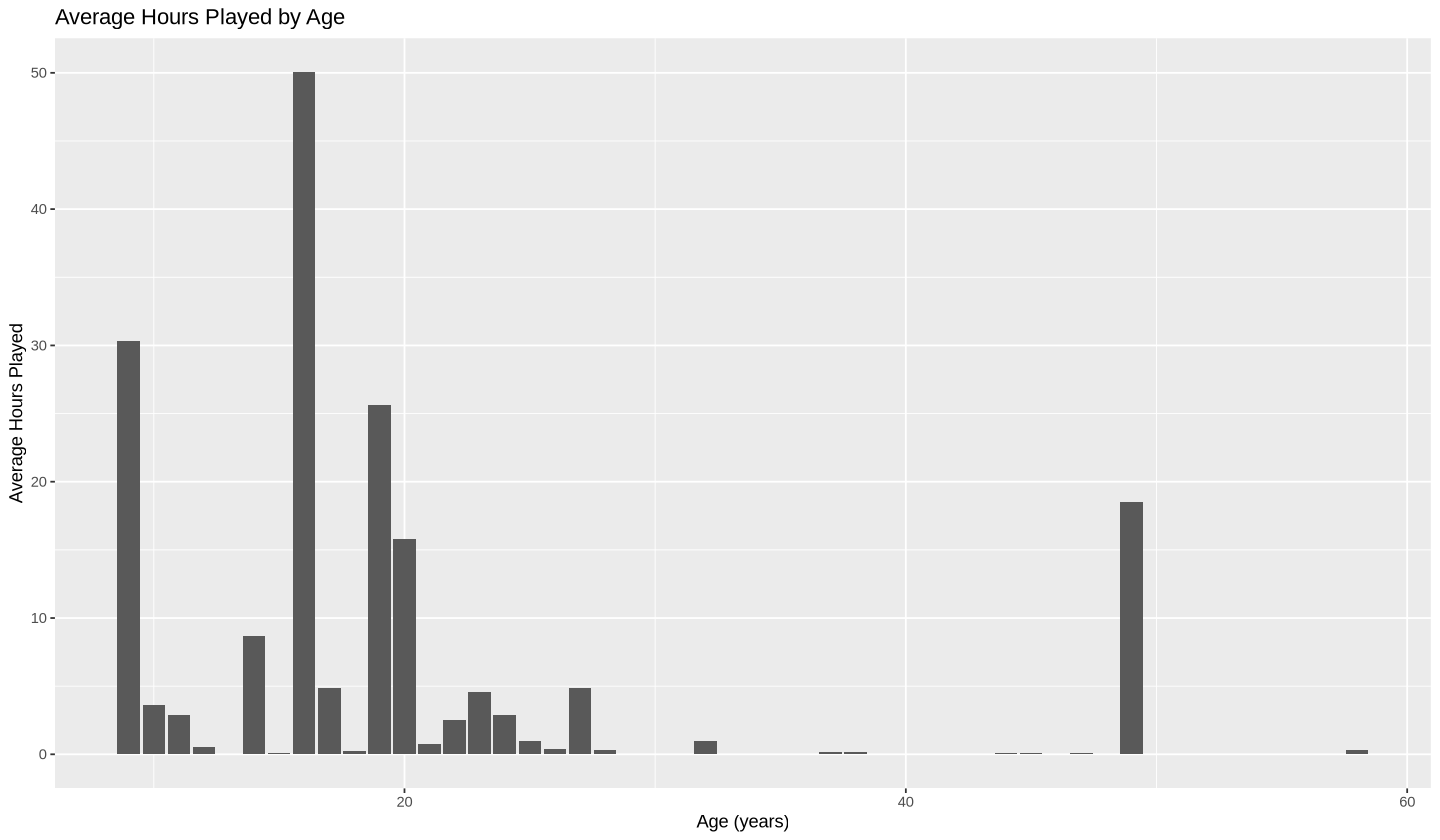

In [109]:
avg_plot <- players |>
            group_by(age) |>
            summarise(avg_hours = mean(played_hours, na.rm = TRUE)) |>
            ggplot(aes(x = age, y = avg_hours)) +
            geom_bar(stat="identity") +
            labs(title = "Average Hours Played by Age", x = "Age (years)", y = "Average Hours Played")
avg_plot

The highest average hours are played by roughly 17-year-olds, who also make up the majority of players. Other higher averages include 9 and 20 years old, suggesting that younger players are both highly active and likely the most informative demographic for classification.

## Methods and Plan